# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [16]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.rnn_layers import *
from deeplearning.captioning_solver import CaptioningSolver
from deeplearning.classifiers.rnn import CaptioningRNN
from deeplearning.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from deeplearning.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `deeplearning/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054130404539434e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `deeplearning/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [20]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.60639146653518e-10
dh error:  3.004141341657747e-10
dc error:  3.498107768721507e-11
dWx error:  1.6933643922734908e-09
dWh error:  4.8937523109148826e-08
db error:  1.7349247160222088e-10


# LSTM: forward
In the function `lstm_forward` in the file `deeplearning/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error around `1e-7`.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `deeplearning/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [6]:
from deeplearning.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.5622504640570264e-09
dh0 error:  2.3832047548384276e-09
dWx error:  1.7818991727993393e-09
dWh error:  9.896887604444883e-07
db error:  2.2831274584857338e-10


# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `deeplearning/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.824459354432268
expected loss:  9.82445935443
difference:  2.26840768391412e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see losses less than 0.5.

In [7]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.830542
(Iteration 21 / 100) loss: 30.053196


KeyboardInterrupt: 

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

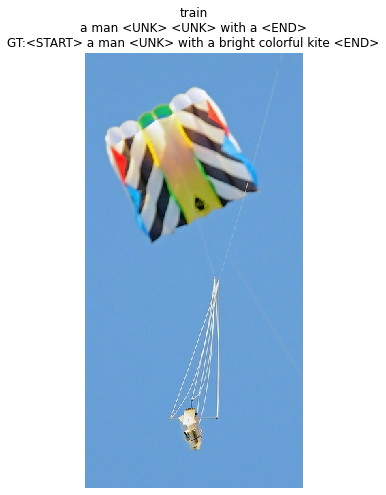

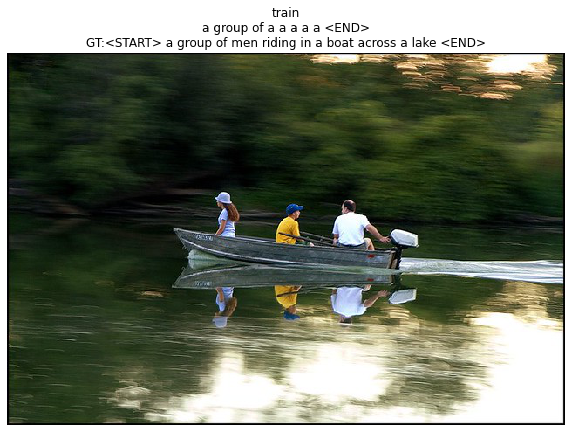

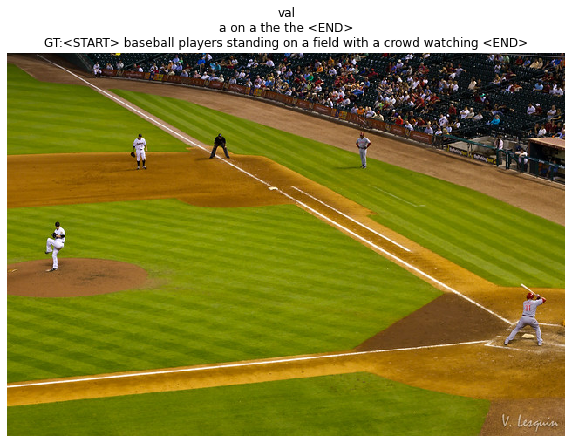

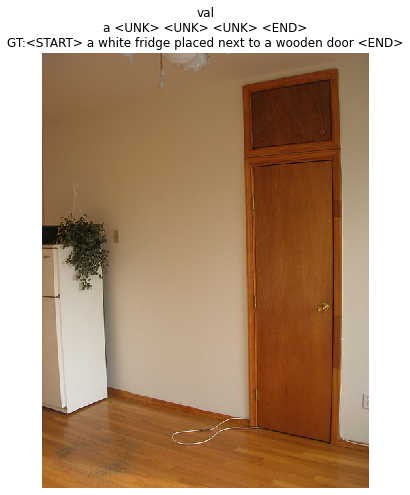

In [8]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        image = image_from_url(url)
        if image is None:
            continue
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Extra Credit: Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validation set that are better than random.

In addition to qualitatively evaluating your model by inspecting its results, you can also quantitatively evaluate your model using the BLEU unigram precision metric. We'll give you a small amount of extra credit if you can train a model that achieves a BLEU unigram score of >0.3. BLEU scores range from 0 to 1; the closer to 1, the better. Here's a reference to the [paper](http://www.aclweb.org/anthology/P02-1040.pdf) that introduces BLEU if you're interested in learning more about how it works.

Feel free to use PyTorch or TensorFlow for this section if you'd like to train faster on a GPU... though you can definitely get above 0.3 using your Numpy code. We're providing you the evaluation code that is compatible with the Numpy model as defined above... you should be able to adapt it for TensorFlow/PyTorch if you go that route.

**Note that you must call save_model_prediction in order to save your model prediction to receive extra credit!**

In [24]:
import nltk

def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['val', 'train']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])
        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])
        #print(sample_captions)
        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))
        
def save_model_prediction(model):
    """
    Save the model prediction for autograding
    """
    minibatch = sample_coco_minibatch(data, split='val', batch_size=1000)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    save_data = {
        'sample_captions': sample_captions,
        'gt_captions': gt_captions
    }

    with open('captioning_extra_credit.pkl', 'wb') as fout:
        pickle.dump(save_data, fout)

Average BLEU score for train: 0.153143
Average BLEU score for val: 0.152406


In [21]:
from builtins import range
from builtins import object
import numpy as np
from deeplearning.layers import relu_forward, relu_backward


class CustomRNN(object):
    """
    A CustomRNN produces captions from image features using a recurrent
    neural network.
    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.
    Note that we don't use any regularization for the CustomRNN.
    """

    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, rnn_layers=2,
                 cell_type='rnn', dtype=np.float32):
        """
        Construct a new CaptioningRNN instance.
        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.rnn_layers = rnn_layers
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)

        # Initialize word vectors
        self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
        self.params['W_embed'] /= 100

        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
        for i in range(rnn_layers):
            # Initialize CNN -> hidden state projection parameters
            self.params['W_proj%d'%(i)] = np.random.randn(input_dim, hidden_dim)
            self.params['W_proj%d'%(i)] /= np.sqrt(input_dim)
            self.params['b_proj%d'%(i)] = np.zeros(hidden_dim)

            # Initialize parameters for the RNN
            if i == 0:
                in_dim = wordvec_dim
            else:
                in_dim = hidden_dim
            self.params['Wx%d'%(i)] = np.random.randn(in_dim, dim_mul * hidden_dim)
            self.params['Wx%d'%(i)] /= np.sqrt(in_dim)
            self.params['Wh%d'%(i)] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
            self.params['Wh%d'%(i)] /= np.sqrt(hidden_dim)
            self.params['b%d'%(i)] = np.zeros(dim_mul * hidden_dim)

            if i < rnn_layers - 1:
                out_dim = hidden_dim
            else:
                out_dim = vocab_size
            self.params['W_hidden%d'%(i)] = np.random.randn(hidden_dim, out_dim)
            self.params['W_hidden%d'%(i)] /= np.sqrt(hidden_dim)
            self.params['b_hidden%d'%(i)] = np.zeros(out_dim)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)


    def loss(self, features, captions):
        """
        Compute training-time loss for the RNN. We input image features and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss and gradients on all parameters.
        Inputs:
        - features: Input image features, of shape (N, D)
        - captions: Ground-truth captions; an integer array of shape (N, T) where
          each element is in the range 0 <= y[i, t] < V
        Returns a tuple of:
        - loss: Scalar loss
        - grads: Dictionary of gradients parallel to self.params
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # You'll need this
        mask = (captions_out != self._null)

        loss, grads = 0.0, {}
        cache = {}

        # Forward
        output_rnn = None
        input_rnn, cache['word_embed'] = word_embedding_forward(captions_in, self.params['W_embed'])
        for i in range(self.rnn_layers):
            W_proj, b_proj = self.params['W_proj%d'%(i)], self.params['b_proj%d'%(i)]
            Wx, Wh, b = self.params['Wx%d'%(i)], self.params['Wh%d'%(i)], self.params['b%d'%(i)]
            W_hidden, b_hidden = self.params['W_hidden%d'%(i)], self.params['b_hidden%d'%(i)]

            h0 = features.dot(W_proj) + b_proj

            if self.cell_type is 'rnn':
                h, cache['rnn%d'%(i)] = rnn_forward(input_rnn, h0, Wx, Wh, b)
            elif self.cell_type is 'lstm':
                h, cache['lstm%d'%(i)] = lstm_forward(input_rnn, h0, Wx, Wh, b)
                
            output_rnn, cache['temp_affine%d'%(i)] = temporal_affine_forward(h, W_hidden, b_hidden)

            if i < self.rnn_layers - 1:
                input_rnn, cache['relu%d'%(i)] = relu_forward(output_rnn)

        loss, d_temp_affine = temporal_softmax_loss(output_rnn, captions_out, mask)

        # Backward
        for i in range(self.rnn_layers-1, -1, -1):
            if i < self.rnn_layers - 1:
                d_temp_affine = relu_backward(d_temp_affine, cache['relu%d'%(i)])

            dh, grads['W_hidden%d'%(i)], grads['b_hidden%d'%(i)] =\
                temporal_affine_backward(d_temp_affine, cache['temp_affine%d'%(i)])

            if self.cell_type is 'rnn':
                d_temp_affine, d_h0, grads['Wx%d'%(i)], grads['Wh%d'%(i)], grads['b%d'%(i)] = \
                  rnn_backward(dh, cache['rnn%d'%(i)])
            elif self.cell_type is 'lstm':
                d_temp_affine, d_h0, grads['Wx%d'%(i)], grads['Wh%d'%(i)], grads['b%d'%(i)] = \
                  lstm_backward(dh, cache['lstm%d'%(i)])

            grads['b_proj%d'%(i)] = d_h0.sum(axis=0)
            grads['W_proj%d'%(i)] = features.T.dot(d_h0)

        grads['W_embed'] = word_embedding_backward(d_temp_affine, cache['word_embed'])

        return loss, grads


    def sample(self, features, max_length=30):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.
        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the input image features, and the initial word is the <START>
        token.
        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.
        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.
        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        cache = {}
        for i in range(self.rnn_layers):
            W_proj, b_proj = self.params['W_proj%d'%(i)], self.params['b_proj%d'%(i)]
            cache['h_prev%d'%(i)] = features.dot(W_proj) + b_proj
            if self.cell_type is 'lstm':
                cache['c_prev%d'%(i)] = np.zeros_like(cache['h_prev%d'%(i)])

        W_embed = self.params['W_embed']
        input_rnn = W_embed[self._start,:] * np.ones((N, W_embed.shape[1]))
        captions[:, 0] = self._start
        for t in range(1, max_length):
            output_rnn = None
            for i in range(self.rnn_layers):
                # rnn
                Wx, Wh, b = self.params['Wx%d'%(i)], self.params['Wh%d'%(i)], self.params['b%d'%(i)]
                if self.cell_type is 'rnn':
                    h_t, _ = rnn_step_forward(input_rnn, cache['h_prev%d'%(i)], Wx, Wh, b)
                elif self.cell_type is 'lstm':
                    h_t, cache['c_prev%d'%(i)], _ = lstm_step_forward(input_rnn, cache['h_prev%d'%(i)], cache['c_prev%d'%(i)], Wx, Wh, b)
                cache['h_prev%d'%(i)] = h_t

                # temporal affine
                W_hidden, b_hidden = self.params['W_hidden%d'%(i)], self.params['b_hidden%d'%(i)]
                output_rnn = h_t.dot(W_hidden) + b_hidden
                if i < self.rnn_layers - 1:
                    input_rnn, _ = relu_forward(output_rnn)

            word_t = np.argmax(output_rnn, axis=1)
            captions[:, t] = word_t

            input_rnn = W_embed[word_t, :]

        return captions

In [22]:

np.random.seed(231)

data = load_coco_data(max_train=1000)

lstm_model = CustomRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=256,
          wordvec_dim=256,
          rnn_layers=2, # you can add more rnn layers
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, data,
           update_rule='adam',
           num_epochs=200,
           batch_size=32,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=150,
         )

lstm_solver.train()

# Plot the training losses
plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 6200) loss: 74.206599
(Iteration 151 / 6200) loss: 31.914117
(Iteration 301 / 6200) loss: 24.612584


KeyboardInterrupt: 

In [23]:
evaluate_model(lstm_model)

Average BLEU score for val: 0.212576
Average BLEU score for train: 0.402836


In [25]:
save_model_prediction(lstm_model)

In [ ]:
import nltk

np.random.seed(231)

med_data = load_coco_data(max_train=1500)

med_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=800,
          wordvec_dim=400,
          dtype=np.float32,
        )

med_lstm_solver = CaptioningSolver(med_lstm_model, med_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=100,
         )

med_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

evaluate_model(med_lstm_model)

(Iteration 1 / 3000) loss: 76.973772
(Iteration 101 / 3000) loss: 40.102921
(Iteration 201 / 3000) loss: 27.728184
(Iteration 301 / 3000) loss: 19.302371
(Iteration 401 / 3000) loss: 13.736465
(Iteration 501 / 3000) loss: 8.291034
(Iteration 601 / 3000) loss: 4.570409
(Iteration 701 / 3000) loss: 5.582371
(Iteration 801 / 3000) loss: 6.455457
(Iteration 901 / 3000) loss: 1.193354
(Iteration 1001 / 3000) loss: 1.191022
(Iteration 1101 / 3000) loss: 0.825751
(Iteration 1201 / 3000) loss: 0.371875
(Iteration 1301 / 3000) loss: 0.245688
(Iteration 1401 / 3000) loss: 0.166562
(Iteration 1501 / 3000) loss: 0.224631
(Iteration 1601 / 3000) loss: 0.223688
(Iteration 1701 / 3000) loss: 0.141211
(Iteration 1801 / 3000) loss: 0.167156
(Iteration 1901 / 3000) loss: 0.086460
(Iteration 2001 / 3000) loss: 0.073222
(Iteration 2101 / 3000) loss: 0.084401
(Iteration 2201 / 3000) loss: 0.060908
(Iteration 2301 / 3000) loss: 0.054154
(Iteration 2401 / 3000) loss: 0.156333
(Iteration 2501 / 3000) loss: 0.

In [35]:
evaluate_model(med_lstm_model)

Average BLEU score for train: 0.237658
Average BLEU score for val: 0.226951


In [11]:



class Captionimage(object):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', dtype=np.float32):
        
        if cell_type not in {'rnn', 'lstm','other'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)

        # Initialize word vectors
        self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
        self.params['W_embed'] /= 100

        # Initialize CNN -> hidden state projection parameters
        self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
        self.params['W_proj'] /= np.sqrt(input_dim)
        self.params['b_proj'] = np.zeros(hidden_dim)

        # Initialize parameters for the RNN
        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
        self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params['Wx'] /= np.sqrt(wordvec_dim)
        self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
        self.params['Wh'] /= np.sqrt(hidden_dim)
        self.params['b'] = np.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights
        self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
        self.params['W_vocab'] /= np.sqrt(hidden_dim)
        self.params['b_vocab'] = np.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)


    def loss(self, features, captions):
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # You'll need this
        mask = (captions_out != self._null)
        # Weight and bias for the affine transform from image features to initial
        # hidden state
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        # Word embedding matrix
        W_embed = self.params['W_embed']

        # Input-to-hidden, hidden-to-hidden, and biases for the RNN
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

        # Weight and bias for the hidden-to-vocab transformation.
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        loss, grads = 0.0, {}
        h0=features.dot(W_proj)+b_proj
        x,cache_embed=word_embedding_forward(captions_in, W_embed)
        if self.cell_type=='rnn':
            h,cache_rnn=rnn_forward(x,h0, Wx,Wh,b)
        elif self.cell_type=='lstm':
            h,cache_lstm=lstm_forward(x,h0, Wx,Wh,b)
        elif self.cell_type=='other':
            h,cache_other=other_forward(x,h0,Wx,Wh,b)
        scores, cache_aff=temporal_affine_forward(h,W_vocab, b_vocab)
        loss, dscores=temporal_softmax_loss(scores, captions_out, mask)
        
        #backward
        dh, dW_v, db_v = temporal_affine_backward(dscores, cache_aff)
        if self.cell_type=='rnn':
            dx,dh0, dWx,dWh, db=rnn_backward(dh,cache_rnn)
        elif self.cell_type=='lstm':
            dx,dh0,dWx, dWh, db=lstm_backward(dh,cache_lstm)
        elif self.cell_type=='other':
            dx,dh0,dWx, dWh, db=other_backward(dh,cache_lstm)
        grads['W_vocab']=dW_v
        grads['b_vocab']=db_v
        grads['Wx'] = dWx
        grads['Wh'] = dWh
        grads['b'] = db
        grads['W_embed']=word_embedding_backward(dx,cache_embed)
        grads['W_proj']=np.matmul(features.T, dh0)
        grads['b_proj']=np.sum(dh0,axis=0)
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads
    def sample(self, features, max_length=30):
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        # Unpack parameters
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        W_embed = self.params['W_embed']
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        curr_h = features.dot(W_proj) + b_proj # initial hidden state
        curr_c = 0
        curr_words = self._start * np.ones(N, dtype=np.int32) # input words
        # step through sequence
        for t in range(max_length):
            x, _ = word_embedding_forward(curr_words, W_embed) 
            if self.cell_type == 'rnn':
                curr_h, _ = rnn_step_forward(x, curr_h, Wx, Wh, b)
            elif self.cell_type == 'lstm':  
                curr_h, curr_c, _ = lstm_step_forward(x, curr_h, curr_c, Wx, Wh, b)
            scores, _ = temporal_affine_forward(curr_h[:, np.newaxis, :], 
                                                W_vocab, b_vocab)
           
            # choose word with max score
            curr_words = np.argmax(np.squeeze(scores), axis=1) 
            captions[:,t] = curr_words
                                       ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return captions

